In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [2]:
import os
DATASET = "E:/4-2/Eurosat Dataset/2750"

LABELS = os.listdir(DATASET)
print(LABELS)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


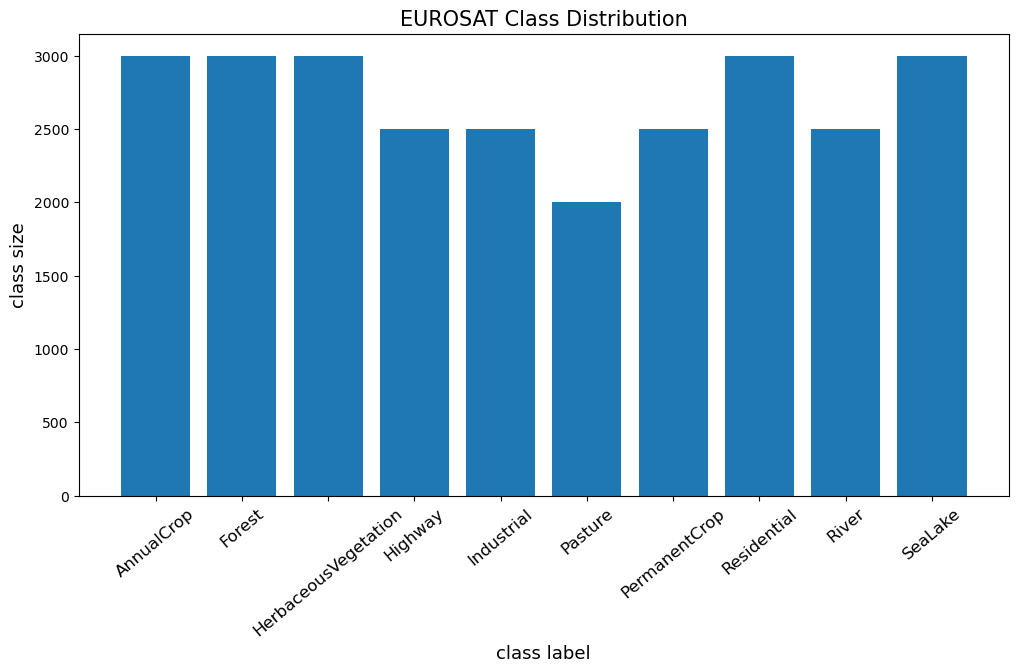

In [3]:
# plot class distributions of whole dataset
import matplotlib.pyplot as plt
counts = {}

for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(DATASET, l)))

    
plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

In [4]:
import PIL
img_paths = [os.path.join(DATASET, l, f"{l}_1000.jpg") for l in LABELS]
img_paths += [os.path.join(DATASET, l, f"{l}_2000.jpg") for l in LABELS]

def plot_sat_imgs(paths):
    plt.figure(figsize=(15, 8))
    for i, path in enumerate(paths[:20]):
        label = os.path.basename(os.path.dirname(path))
        plt.subplot(4, 5, i+1)
        img = PIL.Image.open(path)
        plt.imshow(np.asarray(img))
        plt.title(label)
        plt.xticks([])  
        plt.yticks([])  
    plt.show()

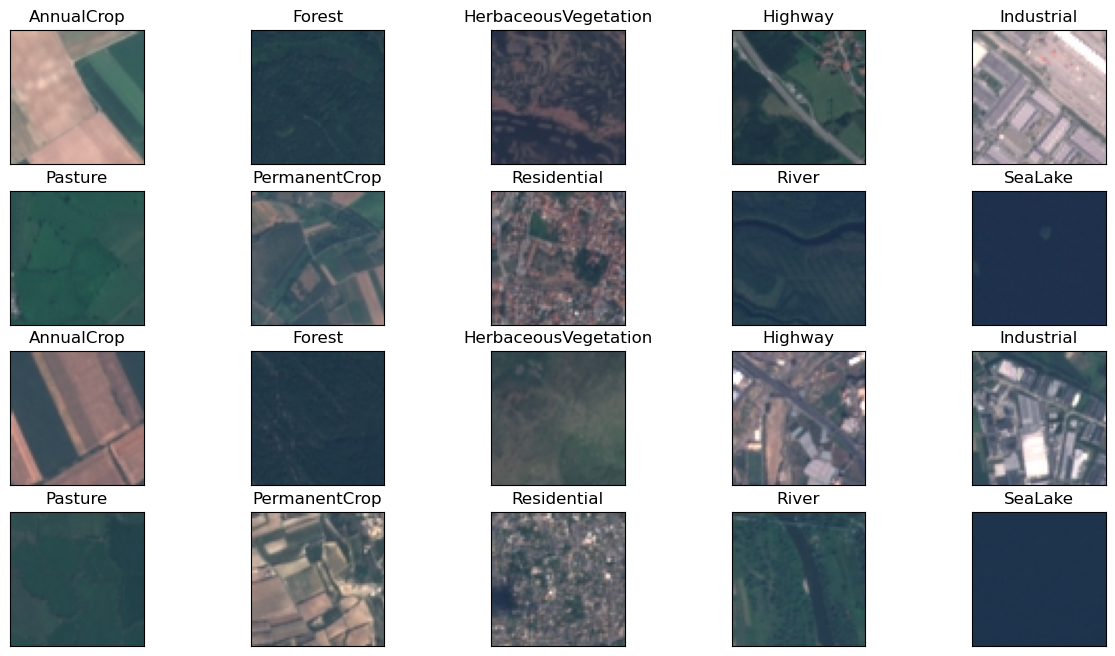

In [5]:
plot_sat_imgs(img_paths)

In [6]:
#Preprocessing

In [7]:
import re
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = 'E:/4-2/Eurosat Dataset/ResNet50/Training'
TEST_DIR = 'E:/4-2/Eurosat Dataset/ResNet50/Testing'
BATCH_SIZE = 64
NUM_CLASSES=len(LABELS)
INPUT_SHAPE = (64, 64, 3)
CLASS_MODE = 'categorical'

# create training and testing directories
for path in (TRAIN_DIR, TEST_DIR):
    if not os.path.exists(path):
        os.mkdir(path)

# create class label subdirectories in train and test
for l in LABELS:
    
    if not os.path.exists(os.path.join(TRAIN_DIR, l)):
        os.mkdir(os.path.join(TRAIN_DIR, l))

    if not os.path.exists(os.path.join(TEST_DIR, l)):
        os.mkdir(os.path.join(TEST_DIR, l))

In [8]:
import pandas as pd
from tqdm import tqdm
import shutil

# map each image path to their class label in 'data'
data = {}

for l in LABELS:
    for img in os.listdir(DATASET+'/'+l):
        data.update({os.path.join(DATASET, l, img): l})

X = pd.Series(list(data.keys()))
y = pd.get_dummies(pd.Series(data.values()))

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=69)

# split the list of image paths
for train_idx, test_idx in split.split(X, y):
    
    train_paths = X[train_idx]
    test_paths = X[test_idx]

    # define a new path for each image depending on training or testing
    new_train_paths = [re.sub('E:/4-2/Eurosat Dataset/2750', 'E:/4-2/Eurosat Dataset/ResNet50/Training', i) for i in train_paths]
    new_test_paths = [re.sub('E:/4-2/Eurosat Dataset/2750', 'E:/4-2/Eurosat Dataset/ResNet50/Testing', i) for i in test_paths]

    train_path_map = list((zip(train_paths, new_train_paths)))
    test_path_map = list((zip(test_paths, new_test_paths)))
    
    # move the files
    print("moving training files..")
    for i in tqdm(train_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])
    
    print("moving testing files..")
    for i in tqdm(test_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])

moving training files..


100%|███████████████████████████████████████████████████████████████████████████| 21600/21600 [01:00<00:00, 354.54it/s]


moving testing files..


100%|█████████████████████████████████████████████████████████████████████████████| 5400/5400 [00:14<00:00, 369.16it/s]


In [9]:
# Create a ImageDataGenerator Instance which can be used for data augmentation

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True
#   validation_split=0.2
)

train_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    #subset='training',
    color_mode='rgb',
    shuffle=True,
    seed=69
)
# The validation set is optional if we choose to do that
"""
valid_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    subset='validation',    
    color_mode='rgb',
    shuffle=True,
    seed=69
)
"""
# test generator for evaluation purposes with no augmentations, just rescaling
test_gen = ImageDataGenerator(
    rescale=1./255,
)

test_generator = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [10]:
print(train_generator.class_indices)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [11]:
np.save('class_indices', train_generator.class_indices)

In [12]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam


from keras.applications import VGG16, VGG19
from keras.applications import ResNet50, ResNet50V2, ResNet152V2
from keras.applications import InceptionV3, Xception

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, fbeta_score, accuracy_score

In [13]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")    
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
    
tf.config.set_soft_device_placement(True)

In [14]:
# Note that for different CNN models we are using different setup of dense layers
def compile_model(cnn_base, input_shape, n_classes, optimizer, fine_tune=None):
    
    if (cnn_base == 'ResNet50') or (cnn_base == 'ResNet50V2') or (cnn_base == 'ResNet152V2'):
        if cnn_base == 'ResNet50':
            conv_base = ResNet50(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        elif cnn_base == 'ResNet50V2':
            conv_base = ResNet50V2(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        else:
            conv_base = ResNet152V2(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        top_model = conv_base.output
        top_model = Flatten()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
       
    
    elif (cnn_base == 'VGG16') or (cnn_base == 'VGG19'):
        if cnn_base == 'VGG16':
            conv_base = VGG16(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        else:
            conv_base = VGG19(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        top_model = conv_base.output
        top_model = Flatten()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
    
    
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    model = Model(inputs=conv_base.input, outputs=output_layer)
        
    if type(fine_tune) == int:
        for layer in conv_base.layers[fine_tune:]:
            layer.trainable = True
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                 metrics=['categorical_accuracy'])
    
    return model

def plot_history(history):
       
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.show();

def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T
    results.rename(columns={0: 'Precision',
                           1: 'Recall',
                           2: 'F-Score',
                           3: 'Support'}, inplace=True)
    
    conf_mat = pd.DataFrame(confusion_matrix(y_true, y_preds), 
                            columns=class_labels,
                            index=class_labels)    
    f2 = fbeta_score(y_true, y_preds, beta=2, average='micro')
    accuracy = accuracy_score(y_true, y_preds)
    print(f"Accuracy: {accuracy}")
    print(f"Global F2 Score: {f2}")    
    return results, conf_mat

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = np.argmax(y_preds[idx])
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))    


In [15]:
N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='E:/4-2/Eurosat Dataset/ResNet50/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [16]:
#ResNet50 Model

In [17]:
resnet50_model = compile_model('ResNet50', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-2), fine_tune=None)
resnet50_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 70, 70, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 32, 32, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 32, 32, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 16, 16, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 16, 16, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 16, 16, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 8, 8, 512)            66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 8, 8, 512)            2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 8, 8, 512)            0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 4, 4, 256)            590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 4, 4, 256)            1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 4, 4, 256)            0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 4, 4, 1024)           525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 4, 4, 1024)           0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 4, 4, 256)            262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 4, 4, 256)            1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 4, 4, 1024)           4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 4, 4, 1024)           0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 4, 4, 1024)           0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 2, 2, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 2, 2, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 2, 2, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 2, 2, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [18]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='E:/4-2/Eurosat Dataset/ResNet50/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [19]:
# First Pretraining the dense layer
resnet50_history = resnet50_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

C:\Users\Bharathi Dhereddy\AppData\Local\Temp\ipykernel_23136\2518429192.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  resnet50_history = resnet50_model.fit_generator(train_generator,


Epoch 1/50



337/337 [==============================] - ETA: 0s - loss: 1.9117 - categorical_accuracy: 0.3049
Epoch 1: val_categorical_accuracy improved from -inf to 0.40513, saving model to E:/4-2/Eurosat Dataset/ResNet50\model.weights.best.hdf5


C:\Users\Bharathi Dhereddy\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


337/337 [==============================] - 433s 1s/step - loss: 1.9117 - categorical_accuracy: 0.3049 - val_loss: 1.6129 - val_categorical_accuracy: 0.4051
Epoch 2/50
337/337 [==============================] - ETA: 0s - loss: 1.5898 - categorical_accuracy: 0.4035
Epoch 2: val_categorical_accuracy improved from 0.40513 to 0.43080, saving model to E:/4-2/Eurosat Dataset/ResNet50\model.weights.best.hdf5
337/337 [==============================] - 1278s 4s/step - loss: 1.5898 - categorical_accuracy: 0.4035 - val_loss: 1.4652 - val_categorical_accuracy: 0.4308
Epoch 3/50
337/337 [==============================] - ETA: 0s - loss: 1.5196 - categorical_accuracy: 0.4282
Epoch 3: val_categorical_accuracy improved from 0.43080 to 0.50521, saving model to E:/4-2/Eurosat Dataset/ResNet50\model.weights.best.hdf5
337/337 [==============================] - 2032s 6s/step - loss: 1.5196 - categorical_accuracy: 0.4282 - val_loss: 1.4085 - val_categorical_accuracy: 0.5052
Epoch 4/50
337/337 [==============

Epoch 24/50
337/337 [==============================] - ETA: 0s - loss: 1.2870 - categorical_accuracy: 0.5220
Epoch 24: val_categorical_accuracy did not improve from 0.58166
337/337 [==============================] - 210s 623ms/step - loss: 1.2870 - categorical_accuracy: 0.5220 - val_loss: 1.2566 - val_categorical_accuracy: 0.5640
Epoch 25/50
337/337 [==============================] - ETA: 0s - loss: 1.2787 - categorical_accuracy: 0.5296
Epoch 25: val_categorical_accuracy did not improve from 0.58166
337/337 [==============================] - 203s 603ms/step - loss: 1.2787 - categorical_accuracy: 0.5296 - val_loss: 1.2718 - val_categorical_accuracy: 0.5525
Epoch 26/50
337/337 [==============================] - ETA: 0s - loss: 1.2901 - categorical_accuracy: 0.5242
Epoch 26: val_categorical_accuracy did not improve from 0.58166
337/337 [==============================] - 218s 648ms/step - loss: 1.2901 - categorical_accuracy: 0.5242 - val_loss: 1.2329 - val_categorical_accuracy: 0.5006
Epoc

Epoch 48/50
337/337 [==============================] - ETA: 0s - loss: 1.2123 - categorical_accuracy: 0.5561
Epoch 48: val_categorical_accuracy improved from 0.59524 to 0.60026, saving model to E:/4-2/Eurosat Dataset/ResNet50\model.weights.best.hdf5
337/337 [==============================] - 537s 2s/step - loss: 1.2123 - categorical_accuracy: 0.5561 - val_loss: 1.1190 - val_categorical_accuracy: 0.6003
Epoch 49/50
337/337 [==============================] - ETA: 0s - loss: 1.2255 - categorical_accuracy: 0.5509
Epoch 49: val_categorical_accuracy did not improve from 0.60026
337/337 [==============================] - 564s 2s/step - loss: 1.2255 - categorical_accuracy: 0.5509 - val_loss: 1.1805 - val_categorical_accuracy: 0.5737
Epoch 50/50
337/337 [==============================] - ETA: 0s - loss: 1.2127 - categorical_accuracy: 0.5567
Epoch 50: val_categorical_accuracy did not improve from 0.60026
337/337 [==============================] - 205s 608ms/step - loss: 1.2127 - categorical_accu

In [20]:
# re-train whole network end2end 
resnet50_model = compile_model('ResNet50', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-4), fine_tune=0)

resnet50_model.load_weights('E:/4-2/Eurosat Dataset/ResNet50/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

resnet50_history = resnet50_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

C:\Users\Bharathi Dhereddy\AppData\Local\Temp\ipykernel_23136\1827416536.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  resnet50_history = resnet50_model.fit_generator(train_generator,


Epoch 1/100
337/337 [==============================] - ETA: 0s - loss: 1.2782 - categorical_accuracy: 0.7695
Epoch 1: val_categorical_accuracy did not improve from 0.60026
337/337 [==============================] - 603s 2s/step - loss: 1.2782 - categorical_accuracy: 0.7695 - val_loss: 7.4586 - val_categorical_accuracy: 0.1071 - lr: 0.0010
Epoch 2/100
337/337 [==============================] - ETA: 0s - loss: 0.6875 - categorical_accuracy: 0.8413
Epoch 2: val_categorical_accuracy did not improve from 0.60026
337/337 [==============================] - 1256s 4s/step - loss: 0.6875 - categorical_accuracy: 0.8413 - val_loss: 3.7873 - val_categorical_accuracy: 0.1782 - lr: 0.0010
Epoch 3/100
337/337 [==============================] - ETA: 0s - loss: 0.4141 - categorical_accuracy: 0.8718  
Epoch 3: val_categorical_accuracy did not improve from 0.60026
337/337 [==============================] - 25711s 77s/step - loss: 0.4141 - categorical_accuracy: 0.8718 - val_loss: 2.7017 - val_categorical_a

Epoch 24/100
337/337 [==============================] - ETA: 0s - loss: 0.0917 - categorical_accuracy: 0.9674
Epoch 24: val_categorical_accuracy did not improve from 0.97247
337/337 [==============================] - 943s 3s/step - loss: 0.0917 - categorical_accuracy: 0.9674 - val_loss: 0.1301 - val_categorical_accuracy: 0.9615 - lr: 6.2500e-05
Epoch 25/100
337/337 [==============================] - ETA: 0s - loss: 0.0822 - categorical_accuracy: 0.9712
Epoch 25: val_categorical_accuracy improved from 0.97247 to 0.97284, saving model to E:/4-2/Eurosat Dataset/ResNet50\model.weights.best.hdf5
337/337 [==============================] - 803s 2s/step - loss: 0.0822 - categorical_accuracy: 0.9712 - val_loss: 0.0871 - val_categorical_accuracy: 0.9728 - lr: 3.1250e-05
Epoch 26/100
337/337 [==============================] - ETA: 0s - loss: 0.0782 - categorical_accuracy: 0.9725
Epoch 26: val_categorical_accuracy did not improve from 0.97284
337/337 [==============================] - 559s 2s/step

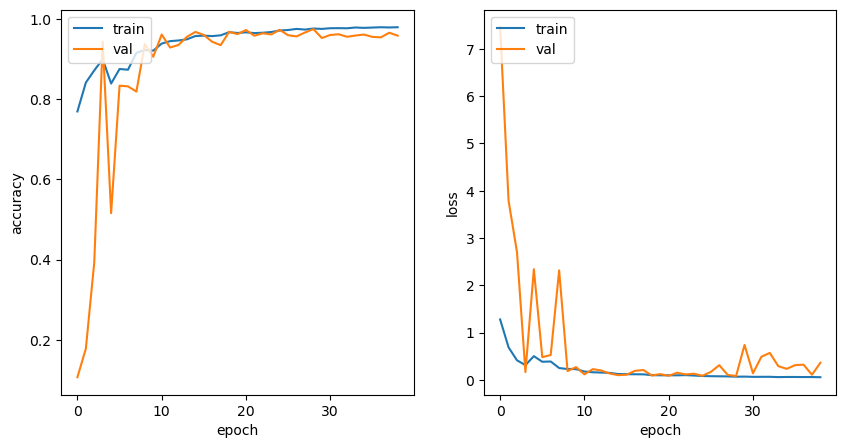

In [21]:
plot_history(resnet50_history)

In [22]:
resnet50_model.load_weights('E:/4-2/Eurosat Dataset/ResNet50/model.weights.best.hdf5')

 class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
 
test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = resnet50_model.predict(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf


Found 5400 images belonging to 10 classes.
5400/5400 [==============================] - 374s 69ms/step
Accuracy: 0.9740740740740741
Global F2 Score: 0.9740740740740741


,Precision,Recall,F-Score,Support
AnnualCrop,0.971667,0.971667,0.971667,600.0
Forest,0.990099,1.000000,0.995025,600.0
HerbaceousVegetation,0.978333,0.978333,0.978333,600.0
Highway,0.981443,0.952000,0.966497,500.0
Industrial,0.991453,0.928000,0.958678,500.0
Pasture,0.982278,0.970000,0.976101,400.0
PermanentCrop,0.958167,0.962000,0.960080,500.0
Residential,0.924499,1.000000,0.960769,600.0
River,0.976190,0.984000,0.980080,500.0
SeaLake,0.996616,0.981667,0.989085,600.0


In [23]:
# Save the model and the weights
resnet50_model.save('E:/4-2/Eurosat Dataset/ResNet50/ResNet50_eurosat.h5')

C:\Users\Bharathi Dhereddy\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


C:\Users\Bharathi Dhereddy\AppData\Local\Temp\ipykernel_23136\2078941242.py:107: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


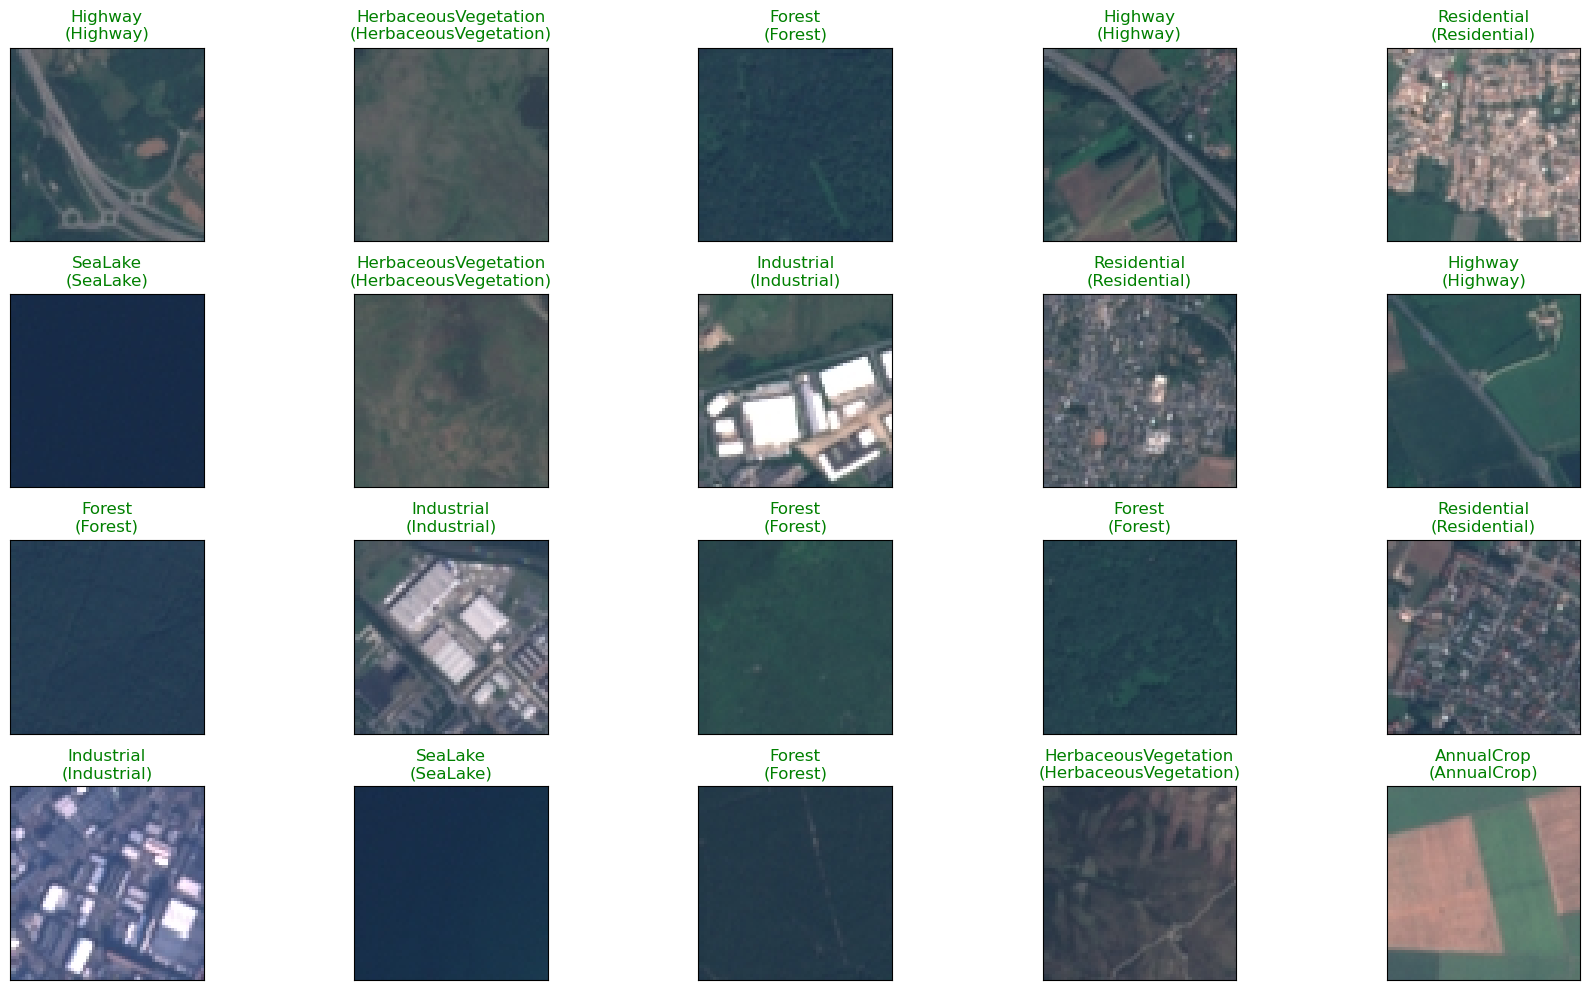

In [24]:
plot_predictions(true_classes, predictions, test_generator_new, class_indices)

In [31]:
import numpy as np
from keras.preprocessing import image

# Load the trained model
model = keras.models.load_model('E:/4-2/Eurosat Dataset/ResNet50/ResNet50_eurosat.h5')

# Define a function to preprocess the input image
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(64, 64))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match batch size
    img_array /= 255.0  # Normalize pixel values
    return img_array

# Define a function to make predictions on the input image
def predict_class(image_path, model):
    preprocessed_img = preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    class_index = np.argmax(predictions)
    confidence = predictions[0][class_index]
    return class_index, confidence

# Input path to the image you want to predict
image_path = 'E:/4-2/Eurosat Dataset/Industry.jpg'

# Make prediction
predicted_class_index, confidence = predict_class(image_path, model)

# Get the class label corresponding to the predicted index
class_labels = {0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}
predicted_class_label = class_labels[predicted_class_index]

# Print the predicted class and confidence
print("Predicted Class:", predicted_class_label)
print("Confidence:", confidence)

1/1 [==============================] - 3s 3s/step
Predicted Class: Industrial
Confidence: 0.99999595


In [32]:
import numpy as np
from keras.preprocessing import image

# Load the trained model
model = keras.models.load_model('E:/4-2/Eurosat Dataset/ResNet50/ResNet50_eurosat.h5')

# Define a function to preprocess the input image
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(64, 64))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match batch size
    img_array /= 255.0  # Normalize pixel values
    return img_array

# Define a function to make predictions on the input image
def predict_class(image_path, model):
    preprocessed_img = preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    class_index = np.argmax(predictions)
    confidence = predictions[0][class_index]
    return class_index, confidence

# Input path to the image you want to predict
image_path = 'E:/4-2/Eurosat Dataset/S.jpg'

# Make prediction
predicted_class_index, confidence = predict_class(image_path, model)

# Get the class label corresponding to the predicted index
class_labels = {0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}
predicted_class_label = class_labels[predicted_class_index]

# Print the predicted class and confidence
print("Predicted Class:", predicted_class_label)
print("Confidence:", confidence)

1/1 [==============================] - 3s 3s/step
Predicted Class: SeaLake
Confidence: 0.99888796


In [33]:
import numpy as np
from keras.preprocessing import image

# Load the trained model
model = keras.models.load_model('E:/4-2/Eurosat Dataset/ResNet50/ResNet50_eurosat.h5')

# Define a function to preprocess the input image
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(64, 64))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match batch size
    img_array /= 255.0  # Normalize pixel values
    return img_array

# Define a function to make predictions on the input image
def predict_class(image_path, model):
    preprocessed_img = preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    class_index = np.argmax(predictions)
    confidence = predictions[0][class_index]
    return class_index, confidence

# Input path to the image you want to predict
image_path = 'E:/4-2/Eurosat Dataset/R.jpg'

# Make prediction
predicted_class_index, confidence = predict_class(image_path, model)

# Get the class label corresponding to the predicted index
class_labels = {0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}
predicted_class_label = class_labels[predicted_class_index]

# Print the predicted class and confidence
print("Predicted Class:", predicted_class_label)
print("Confidence:", confidence)

1/1 [==============================] - 4s 4s/step
Predicted Class: River
Confidence: 0.9996239


In [34]:
import numpy as np
from keras.preprocessing import image

# Load the trained model
model = keras.models.load_model('E:/4-2/Eurosat Dataset/ResNet50/ResNet50_eurosat.h5')

# Define a function to preprocess the input image
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(64, 64))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match batch size
    img_array /= 255.0  # Normalize pixel values
    return img_array

# Define a function to make predictions on the input image
def predict_class(image_path, model):
    preprocessed_img = preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    class_index = np.argmax(predictions)
    confidence = predictions[0][class_index]
    return class_index, confidence

# Input path to the image you want to predict
image_path = 'E:/4-2/Eurosat Dataset/HV.jpg'

# Make prediction
predicted_class_index, confidence = predict_class(image_path, model)

# Get the class label corresponding to the predicted index
class_labels = {0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}
predicted_class_label = class_labels[predicted_class_index]

# Print the predicted class and confidence
print("Predicted Class:", predicted_class_label)
print("Confidence:", confidence)

1/1 [==============================] - 3s 3s/step
Predicted Class: HerbaceousVegetation
Confidence: 0.99991703


In [35]:
import numpy as np
from keras.preprocessing import image

# Load the trained model
model = keras.models.load_model('E:/4-2/Eurosat Dataset/ResNet50/ResNet50_eurosat.h5')

# Define a function to preprocess the input image
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(64, 64))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match batch size
    img_array /= 255.0  # Normalize pixel values
    return img_array

# Define a function to make predictions on the input image
def predict_class(image_path, model):
    preprocessed_img = preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    class_index = np.argmax(predictions)
    confidence = predictions[0][class_index]
    return class_index, confidence

# Input path to the image you want to predict
image_path = 'E:/4-2/Eurosat Dataset/F.jpg'

# Make prediction
predicted_class_index, confidence = predict_class(image_path, model)

# Get the class label corresponding to the predicted index
class_labels = {0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}
predicted_class_label = class_labels[predicted_class_index]

# Print the predicted class and confidence
print("Predicted Class:", predicted_class_label)
print("Confidence:", confidence)


1/1 [==============================] - 3s 3s/step
Predicted Class: Forest
Confidence: 0.99986446


In [36]:
import numpy as np
from keras.preprocessing import image

# Load the trained model
model = keras.models.load_model('E:/4-2/Eurosat Dataset/ResNet50/ResNet50_eurosat.h5')

# Define a function to preprocess the input image
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(64, 64))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match batch size
    img_array /= 255.0  # Normalize pixel values
    return img_array

# Define a function to make predictions on the input image
def predict_class(image_path, model):
    preprocessed_img = preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    class_index = np.argmax(predictions)
    confidence = predictions[0][class_index]
    return class_index, confidence

# Input path to the image you want to predict
image_path = 'E:/4-2/Eurosat Dataset/AC.jpg'

# Make prediction
predicted_class_index, confidence = predict_class(image_path, model)

# Get the class label corresponding to the predicted index
class_labels = {0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}
predicted_class_label = class_labels[predicted_class_index]

# Print the predicted class and confidence
print("Predicted Class:", predicted_class_label)
print("Confidence:", confidence)

1/1 [==============================] - 5s 5s/step
Predicted Class: AnnualCrop
Confidence: 0.9999459


In [37]:
import numpy as np
from keras.preprocessing import image

# Load the trained model
model = keras.models.load_model('E:/4-2/Eurosat Dataset/ResNet50/ResNet50_eurosat.h5')

# Define a function to preprocess the input image
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(64, 64))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match batch size
    img_array /= 255.0  # Normalize pixel values
    return img_array

# Define a function to make predictions on the input image
def predict_class(image_path, model):
    preprocessed_img = preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    class_index = np.argmax(predictions)
    confidence = predictions[0][class_index]
    return class_index, confidence

# Input path to the image you want to predict
image_path = 'E:/4-2/Eurosat Dataset/Past.jpg'

# Make prediction
predicted_class_index, confidence = predict_class(image_path, model)

# Get the class label corresponding to the predicted index
class_labels = {0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}
predicted_class_label = class_labels[predicted_class_index]

# Print the predicted class and confidence
print("Predicted Class:", predicted_class_label)
print("Confidence:", confidence)

1/1 [==============================] - 3s 3s/step
Predicted Class: Pasture
Confidence: 1.0


In [38]:
import numpy as np
from keras.preprocessing import image

# Load the trained model
model = keras.models.load_model('E:/4-2/Eurosat Dataset/ResNet50/ResNet50_eurosat.h5')

# Define a function to preprocess the input image
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(64, 64))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match batch size
    img_array /= 255.0  # Normalize pixel values
    return img_array

# Define a function to make predictions on the input image
def predict_class(image_path, model):
    preprocessed_img = preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    class_index = np.argmax(predictions)
    confidence = predictions[0][class_index]
    return class_index, confidence

# Input path to the image you want to predict
image_path = 'E:/4-2/Eurosat Dataset/PC.jpg'

# Make prediction
predicted_class_index, confidence = predict_class(image_path, model)

# Get the class label corresponding to the predicted index
class_labels = {0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}
predicted_class_label = class_labels[predicted_class_index]

# Print the predicted class and confidence
print("Predicted Class:", predicted_class_label)
print("Confidence:", confidence)

1/1 [==============================] - 2s 2s/step
Predicted Class: PermanentCrop
Confidence: 0.99991095


In [39]:
import numpy as np
from keras.preprocessing import image

# Load the trained model
model = keras.models.load_model('E:/4-2/Eurosat Dataset/ResNet50/ResNet50_eurosat.h5')

# Define a function to preprocess the input image
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(64, 64))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match batch size
    img_array /= 255.0  # Normalize pixel values
    return img_array

# Define a function to make predictions on the input image
def predict_class(image_path, model):
    preprocessed_img = preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    class_index = np.argmax(predictions)
    confidence = predictions[0][class_index]
    return class_index, confidence

# Input path to the image you want to predict
image_path = 'E:/4-2/Eurosat Dataset/High.jpg'

# Make prediction
predicted_class_index, confidence = predict_class(image_path, model)

# Get the class label corresponding to the predicted index
class_labels = {0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}
predicted_class_label = class_labels[predicted_class_index]

# Print the predicted class and confidence
print("Predicted Class:", predicted_class_label)
print("Confidence:", confidence)

1/1 [==============================] - 4s 4s/step
Predicted Class: Highway
Confidence: 0.99997985


In [40]:
import numpy as np
from keras.preprocessing import image

# Load the trained model
model = keras.models.load_model('E:/4-2/Eurosat Dataset/ResNet50/ResNet50_eurosat.h5')

# Define a function to preprocess the input image
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(64, 64))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match batch size
    img_array /= 255.0  # Normalize pixel values
    return img_array

# Define a function to make predictions on the input image
def predict_class(image_path, model):
    preprocessed_img = preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    class_index = np.argmax(predictions)
    confidence = predictions[0][class_index]
    return class_index, confidence

# Input path to the image you want to predict
image_path = 'E:/4-2/Eurosat Dataset/Res.jpg'

# Make prediction
predicted_class_index, confidence = predict_class(image_path, model)

# Get the class label corresponding to the predicted index
class_labels = {0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}
predicted_class_label = class_labels[predicted_class_index]

# Print the predicted class and confidence
print("Predicted Class:", predicted_class_label)
print("Confidence:", confidence)

1/1 [==============================] - 3s 3s/step
Predicted Class: Residential
Confidence: 0.9999999
